In [1]:
# Author : Trong Canh Nguyen

# This script considers all the products a user has ordered
#
# We train a model computing the probability of reorder on the "train" data
#
# For the submission, we keep the orders that have a probability of
# reorder higher than a threshold


import numpy as np
import pandas as pd
import lightgbm as lgb
from helper import *
import gc
IDIR = '../input/'
FEATURES_PATH = './features3/'

In [13]:
gc.collect()

115

## Data Load

In [ ]:
#data = pd.read_csv(FEATURES_PATH + "data.csv", dtype= dtype_dict)

In [3]:
data = pd.read_hdf(FEATURES_PATH + "data.h5", "data_features")
data.reset_index(inplace=True)
print("memory = ", data.memory_usage().sum()/1000000)

memory =  1650.186252


In [8]:
len(list(data.columns))

30

In [9]:
columns = list(data.columns)
not_features = ['user_id', 'product_id', 'aisle_id', 'department_id', 'user_eval_set', 'up_reordered']
features = list(set(columns) - set(not_features))
print("number of features", len(features))

features

number of features 26


['dep_reorder_ratio',
 'user_dep_reordered_ratio',
 'up_orders_since_last_order',
 'product_reorder_ratio',
 'user_reorder_rate',
 'up_order_hour_of_day_mean',
 'user_dep_ratio',
 'up_add_to_cart_order_mean',
 'up_order_rate',
 'up_add_to_cart_order_relative_mean',
 'user_order_hour_of_day',
 'up_order_rate_since_first_order',
 'up_days_since_prior_order_mean',
 'up_recency',
 'up_order_dow_mean',
 'user_order_dow',
 'up_orders',
 'user_aisle_reordered_ratio',
 'user_aisle_ratio',
 'user_total_order',
 'user_days_since_prior_order',
 'user_order_size_mean',
 'user_days_since_prior_mean',
 'product_reorder_probability',
 'up_days_since_last_order',
 'aisle_reorder_ratio']

# MODEL

In [10]:
data_features = data[data.user_eval_set == "train"][['user_id', 'product_id']+ features + ["up_reordered"]]

tmp = data_features.user_id.unique()
user_train = tmp[0:120000]
user_valid = tmp[120000:]

data_train = data_features[data_features.user_id.isin(user_train)]
data_valid = data_features[data_features.user_id.isin(user_valid)]

In [11]:
data_features.to_hdf(FEATURES_PATH + "lgb_data.h5", "data_features", mode="a")
data_train.to_hdf(FEATURES_PATH + "lgb_data.h5", "data_train", mode="a")
data_valid.to_hdf(FEATURES_PATH + "lgb_data.h5", "data_valid", mode="a")

In [14]:
data_test = data[data.user_eval_set == "test"][['user_id', 'product_id']+ features]
data_test.to_hdf(FEATURES_PATH + "lgb_data.h5", "data_test", mode="a")

## Load data_train, data_valid

In [28]:
features = ['dep_reorder_ratio',
 'user_dep_reordered_ratio',
 'up_orders_since_last_order',
 'product_reorder_ratio',
 'user_reorder_rate',
 'up_order_hour_of_day_mean',
 'user_dep_ratio',
 'up_add_to_cart_order_mean',
 'up_order_rate',
 'up_add_to_cart_order_relative_mean',
 'user_order_hour_of_day',
 'up_order_rate_since_first_order',
 'up_days_since_prior_order_mean',
 'up_recency',
 'up_order_dow_mean',
 'user_order_dow',
 'up_orders',
 'user_aisle_reordered_ratio',
 'user_aisle_ratio',
 'user_total_order',
 'user_days_since_prior_order',
 'user_order_size_mean',
 'user_days_since_prior_mean',
 'product_reorder_probability',
 'up_days_since_last_order',
 'aisle_reorder_ratio']

print(len(features))

23


In [4]:
data_train = pd.read_hdf(FEATURES_PATH + "lgb_data.h5", "data_train")
data_valid = pd.read_hdf(FEATURES_PATH + "lgb_data.h5", "data_valid")
print("data_train len", len(data_train))
print("data_valid len", len(data_valid))

#columns = list(data_train.columns)
#not_features = ['user_id', 'product_id', 'up_reordered']
#features = list(set(columns) - set(not_features))
#print("number of features", len(features))
#features

data_train len 7757907
data_valid len 716754


In [29]:
X_train= data_train[features].values
y_train= data_train['up_reordered'].values
X_valid= data_valid[features].values
y_valid= data_valid['up_reordered'].values

In [ ]:
weight_train = 1 - (1- y_train)*0.8
weight_valid = 1 - (1- y_valid)*0.8

In [30]:
print('formating for lgb')
d_train = lgb.Dataset(X_train, label=y_train, feature_name = features)
d_valid = lgb.Dataset(X_valid, label=y_valid, feature_name = features, reference=d_train)
#d_train.save_binary(FEATURES_PATH +  'train.bin')
#d_valid.save_binary(FEATURES_PATH +  'valid.bin')

formating for lgb


In [7]:
gc.collect()

0

In [31]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 100,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 10,
    'learning_rate':0.1
}
ROUNDS = 100

In [32]:
print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)

light GBM train :-)


In [10]:
bst.save_model(FEATURES_PATH + 'lgb/trained_model_new_features_1.txt')

In [36]:
bst.add_valid(d_valid, "valid")

In [34]:
bst.eval_train()

[('training', 'binary_logloss', 0.24483082833233685, False)]

In [37]:
bst.eval_valid()

[('valid', 'binary_logloss', 0.24621613502568943, False)]

## Train on all dataset

In [ ]:
X_all = data_features[features]
y_all = data_features['up_reordered']

In [ ]:
dataset_all = lgb.Dataset(X_all, label=y_all)

In [ ]:
print('light GBM train :-)')
bst_all = lgb.train(params, dataset_all, ROUNDS)

In [ ]:
bst_all.save_model(FEATURES_PATH + 'lgb/trained_model_num_leaves500_ALL.txt')

In [ ]:
bst_all.eval_train()

### Validation

In [6]:
bst = lgb.Booster(model_file=FEATURES_PATH+ 'lgb/trained_model_new_features_1.txt')

In [7]:
pred_valid = bst.predict(X_valid)
pred_valid

array([ 0.04374573,  0.05425192,  0.06251769, ...,  0.12090801,
        0.02268766,  0.1218006 ])

In [8]:
valid_df = data_valid[['user_id', 'product_id']].copy()
valid_df["y"] = y_valid
valid_df["pred"] = pred_valid
valid_df["y_"] = valid_df["pred"]  >= 0.2
valid_df['correct'] = (valid_df['y'] == valid_df['y_']) & (valid_df['y_'])
valid_df.sort_values(['user_id', 'pred'], ascending=[True, False], inplace = True)
#print("valid log loss = ", -((valid_df["y"]*np.log(valid_df["pred"])+ (1.-valid_df["y"])* np.log(1.- valid_df["pred"]))).mean())

In [2]:
valid_df

NameError: name 'valid_df' is not defined

In [40]:
compute_f1(valid_df, 0.21)

0.37843567849675064

In [ ]:
result = valid_df.groupby('user_id').sum()
result['precision'] = result.apply(lambda row: precision(row['y'], row['y_'], row['correct']), axis=1)
result['recall'] = result.apply(lambda row: recall(row['y'], row['y_'], row['correct']), axis=1)
result['f1'] = result.apply(lambda row: f1(row['y'], row['y_'], row['correct']), axis=1)

print("precision mean = ", result.precision.mean())
print("recall mean = ", result.recall.mean())
print("f1 mean = ", result.f1.mean())

In [16]:
#valid_df.to_csv(FEATURES_PATH+ "valid_df.csv")
valid_df.to_hdf(FEATURES_PATH+ "results.h5", "valid_df", mode = "a")

In [ ]:
valid_df.head()

## Generate predictions

In [ ]:
#bst_all = lgb.Booster(model_file=FEATURES_PATH+ 'trained_model.txt')

In [ ]:
data_test = pd.read_hdf(FEATURES_PATH + "lgb_data.h5", "data_test")

In [ ]:
print('light GBM predict')
pred_test = bst.predict(data_test[features])
pred_test

In [ ]:
orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32},
        usecols=["order_id", "user_id", "eval_set"])

test_orders= orders[orders.eval_set == 'test']

In [ ]:
prediction = pd.DataFrame()
prediction[['user_id', 'product_id']] = data_test[['user_id', 'product_id']]
prediction['proba'] = pred_test
prediction.sort_values(by=['user_id', 'proba'], ascending=[True, False], inplace=True)
prediction = pd.merge(prediction, test_orders[['order_id', 'user_id']], on="user_id", how='left')

In [ ]:
prediction

## Feature importance

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

Plot feature importances...


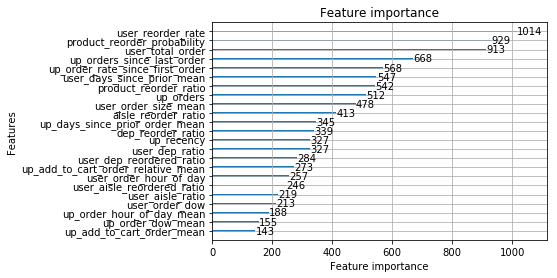

In [33]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=30)
plt.show()


(array([ 1118842.,  1273933.,   789083.,   792538.,   657632.,   471081.,
          386987.,   330695.,   314849.,   258640.,   230614.,   207186.,
          188003.,   161074.,   145381.,   123259.,   110318.,    83088.,
           66781.,    47923.]),
 array([   0.  ,   18.25,   36.5 ,   54.75,   73.  ,   91.25,  109.5 ,
         127.75,  146.  ,  164.25,  182.5 ,  200.75,  219.  ,  237.25,
         255.5 ,  273.75,  292.  ,  310.25,  328.5 ,  346.75,  365.  ]),
 <a list of 20 Patch objects>)

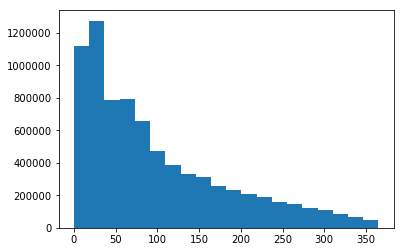

In [20]:
plt.hist(data_train.up_days_since_last_order, bins=20)

### Recommendation using threshold

In [ ]:
threshold = 0.20
recommend = prediction[prediction.proba >= threshold].groupby('order_id').product_id.apply(list)

In [ ]:
recommend.head()

In [ ]:
add_none_df = prediction[prediction.proba >= threshold].groupby('order_id').proba.agg([np.size, np.max])
add_none_df['None'] = (add_none_df['size'] == 1) & (add_none_df['amax'] < 0.4)
add_none_df.head()

In [ ]:
recommend_df = pd.DataFrame()
recommend_df["count"] = prediction.groupby('order_id').size()
recommend_df['product_list'] = recommend
recommend_df['none'] = add_none_df['None']


In [ ]:
recommend_df.head()

In [ ]:
def generate_prediction(row):
    p = row.product_list
    if type(p) == list:
        result = ' '.join([str(x)  for x in p])
        
        if row.none:
            result = 'None ' + result
        
        return result
    else:
        return 'None'

In [ ]:
recommend_df['products']= recommend_df.apply(lambda row:  generate_prediction(row) , axis = 1) 

In [ ]:
recommend_df['products']

In [ ]:
recommend_df['products'].to_csv(FEATURES_PATH +  'lgb/recommend4_none.csv', header = True)

## Investigate result

In [9]:
valid_df = data_valid[['user_id', 'product_id']].copy()
valid_df["y"] = y_valid
valid_df["pred"] = pred_valid

In [10]:
valid_df["y_"] = valid_df["pred"]  >= 0.21
valid_df['correct'] = (valid_df['y'] == valid_df['y_']) & (valid_df['y_'])
valid_df.sort_values(['user_id', 'pred'], ascending=[True, False], inplace = True)
valid_df.head()

,user_id,product_id,y,pred,y_,correct
12176394,188560,46676,0.0,0.239460,True,False
12176382,188560,35140,0.0,0.165058,False,False
12176370,188560,24830,0.0,0.127308,False,False
12176373,188560,27104,0.0,0.127297,False,False
12176359,188560,12932,0.0,0.118119,False,False


In [14]:
threshold_none = 0.5
result = valid_df.groupby('user_id').agg({'y':np.sum,'y_':np.sum, 'correct':np.sum, 'pred':np.max}).reset_index()
result['None'] = (result['y_'] > 0) & (result['y_'] < 4) &(result['pred'] < threshold_none)
result['precision'] = result.apply(lambda row: precision(row['y'], row['y_'], row['correct'], row['None']), axis=1)
result['recall'] = result.apply(lambda row: recall(row['y'], row['y_'], row['correct'], row['None']), axis=1)
result['f1'] = result.apply(lambda row: f1(row['y'], row['y_'], row['correct'], row['None']), axis=1)
print(result.f1.mean())

0.3834601717219649


In [ ]:
result.head()

In [15]:
result[(result.y > 0) & (result.correct == 0)]

,user_id,y,y_,correct,pred,None,precision,recall,f1
0,188560,1.0,1.0,0.0,0.239460,True,0.0,0.0,0.0
1,188562,6.0,0.0,0.0,0.185238,False,1.0,0.0,0.0
4,188568,2.0,1.0,0.0,0.244720,True,0.0,0.0,0.0
6,188570,1.0,1.0,0.0,0.285427,True,0.0,0.0,0.0
10,188577,3.0,2.0,0.0,0.722322,False,0.0,0.0,0.0
14,188584,1.0,1.0,0.0,0.316674,True,0.0,0.0,0.0
17,188589,1.0,4.0,0.0,0.638825,False,0.0,0.0,0.0
20,188593,2.0,6.0,0.0,0.392380,False,0.0,0.0,0.0
21,188595,1.0,4.0,0.0,0.606374,False,0.0,0.0,0.0
28,188607,2.0,3.0,0.0,0.257376,True,0.0,0.0,0.0


In [ ]:
result[(result.y == 0) & (result.y_ == 0)]

In [ ]:
plt.hist(result.f1)

In [ ]:
result[(result.y ==0) & (result.y_ > 0) & (result['None'] == False)]

In [ ]:
459 + 1777 

In [ ]:
len(result[(result.f1 == 0)])

In [ ]:
valid_df[valid_df.user_id == 188562]

In [ ]:
data_valid[(data_valid.user_id == 188562) & (data_valid.product_id  == 43409)].T

In [ ]:
valid_df.to_hdf(FE)